In [1]:
import os
import numpy as np
import pandas as pd
import math
import thinkstats2
import thinkplot
import scipy.optimize as opt
import matplotlib.pyplot as plt
from statistics import mode

## Introduction

Tennis is a sport played throughout the world. There are many variants; we'll be discussing singles tennis in which two players play head-to-head, hitting a ball over a net. A tennis match is the total contest between two players on a day. Matches are played as the best of 3 or 5 sets depending on the tournament rules.

The ATP is the major international governing body for men's tennis, as is WTA for women. These bodies maintain rankings which are based on points accumulated from wins at tournaments. A lower number corresponds to a better ranking, with rank 1 meaning the world's best-ranked. To avoid confusion, I'll use the terms better-ranked and worse-ranked to refer to ranks closer to 1 and further from 1, respectively.

Tennis courts vary greatly. The most salient fact about a court is its type of surface, and today those consist of hard courts (resembling concrete), clay courts, and grass courts. There is substantial variation within each subtype. For example, many hard courts are surfaced with prorietary formulas. The same is true of clay courts. The grass type and rules of grass maintainenance affects play on grass courts. These all have measurable impacts on tennis play.

A tennis tournament begins with a fixed number of players, which is always a power of two. Single elimination play proceeds through "rounds," until one player emerges undefeated in the final match. Players are afforded spots within the tournament according to their rankings, and distributed through the brackets accordingly to guarantee that players with very good rankings cannot meet before later rounds. This is known as "seeding." For our analysis, we will restrict to high-level tournaments, as in these it is typical that the 64 or 128 seeds are very nearly the top 64 or 128 ranked players in the world at the time. At a lesser tournament, the top seeds might be ranked 10th, and the 32nd seed might be ranked number 200.

**The variables**

The variables that I will use are body, surface, tourney_level, tourney_date, winner_rank, loser_rank, rank_diff (recode), and upset (recode). The body refers to the governing body, which is ATP for men and WTA for women. The surface is the type of court surface on which the match was played, and is one of clay, hard, carpet, or grass. The tourney_level variable refers to what level tournament is being played - we'll be focused on the most important tournaments, as they provide the best controls on seed rankings. The winner_rank is the rank of the winner of the match, and the loser_rank is the rank of the loser of the match. I define the recodes rank_diff as the loser rank minus the winner rank, and upset as a match in which the worse-ranked player won.

## The data

My data came in a bunch of separate csv files. There is one sheet per organizing body (ATP = men, WTA = women) per year. I'll combine them all into a single large csv with the following function. The directory location relative to the python file is hard-coded in the first code block. Before running on another machine, it will need to be checked and adjusted.

In [2]:
''' before proceeding, download the data from
    
    https://github.com/cabriggs/upsets-in-tennis/blob/master/tennis_singles_wta.zip
    https://github.com/cabriggs/upsets-in-tennis/blob/master/tennis_singles_atp.zip

    and extract the files to cwd/data
'''

directory = 'data/'

def add_file_to_master(newfile,master,directory=directory):
    # newfile: a file name, no directory
    # master: the file object to be added to, assumed open
    # directory: the location of the files
    new = open(directory+newfile,'r')
    lines = new.readlines()
    for i in range(1,len(lines)):
        master_data.write(newfile[:3]+','+lines[i])
    new.close()

In [3]:
'''Create a master file of atp and wta singles data. I use all years which have a
   good percentage of matches including player rank data.
   atp: 1981-2019
   wta: 1986-2019
'''
try: os.remove(directory+'master_data.csv')
except FileNotFoundError: pass

master_data = open(directory+'master_data.csv','w')
master_data.write('body,'+'tourney_id,tourney_name,surface,draw_size,tourney_level,'\
                  'tourney_date,match_num,winner_id,winner_seed,winner_entry,'\
                  'winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,'\
                  'loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,'\
                  'loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,'\
                  'w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,'\
                  'l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,'\
                  'winner_rank_points,loser_rank,loser_rank_points\n')
for filename in os.listdir(directory):
        if filename[:3] in ['atp','wta']:
            add_file_to_master(filename, master_data)
master_data.close()

Now I'll convert the generated csv to a pandas dataframe.

In [4]:
 df = pd.read_csv(directory+'master_data.csv',low_memory=False)

## Data cleaning and recodes

I'll select only the data used for the study. This is to enhance the performance in the computations.

In [5]:
df = df[['body','surface','tourney_level','tourney_date','round','winner_rank','loser_rank']]

Next I'll drop the rows with NaN in any of the remaining columns.

In [6]:
def drop_na_rows(df, cols = []):
    '''drops all rows from df with NaN in any of cols'''
    for col in cols:
        df = df[df[col].notnull()]
    return df

In [7]:
df = drop_na_rows(df,['body','surface','tourney_level','tourney_date',
                      'round','winner_rank','loser_rank'])

In [8]:
len(df)

212694

We still have over 200,000 observations to work with.



Now for some recodes. I'm interested in the difference between the winner's rank and loser's rank. I'll compute this as loser_rank-winner_rank. Since a lower number is a better rank, a negative difference will correspond to an upset.

In [9]:
df['rank_diff']=df.loser_rank-df.winner_rank

As a reality check, we'll check the median rank_diff. We're expecting a positive number, as on average the better-ranked player should win. If it were 0, that would mean that the rank of players gives no information about who should win a matchup. Using the data overall will give us a noisy picture because the top ranked players only reliably enter Masters and Grand Slam level tournaments. In a Grand Slam tournament one can be sure that the 128 seeds are roughly the players ranked 1-128 in the world at that time. So at the end of the analysis we'll get our tightest control by using Masters and Grand Slam data only.

In the ATP and WTA, the code for Grand Slam tournaments is 'G'. In the ATP, Masters tournaments use 'M', whereas in the WTA these tournaments are called "Premier Mandatory" and so use 'PM'.

In [10]:
df = df[(df.tourney_level=='G') | (df.tourney_level=='PM') | (df.tourney_level=='M')]

I'll add an indicator column for upset.

In [11]:
df['upset']=df.rank_diff<0

Some tennis matches are played as the best of 3 sets, and others are played as the best of 5. It is apples-to-oranges to compare statistics for matches of 3 vs 5 sets, so we'll create a best_of column to be either 3 or 5. The best of 5 tournaments

In [12]:
def best_of(row):
    if (row['body']=='atp' and
            ((row['tourney_level'] in ['D','G']) or
            (row['tourney_level'] == 'M' and row['tourney_date']<20080000))):
        return 5
    else:
        return 3

In [13]:
df['best_of'] = df.apply(best_of, axis = 1)

In [14]:
df[df.tourney_level != 'G'][df.tourney_level != 'D'][df.body == 'wta'].head(10)

<ipython-input-14-51aa2d99d2ca>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.tourney_level != 'G'][df.tourney_level != 'D'][df.body == 'wta'].head(10)


,body,surface,tourney_level,tourney_date,round,winner_rank,loser_rank,rank_diff,upset,best_of
9081,wta,Hard,PM,20100308,R128,42.0,80.0,38.0,False,3
9082,wta,Hard,PM,20100308,R128,97.0,64.0,-33.0,True,3
9083,wta,Hard,PM,20100308,R128,127.0,98.0,-29.0,True,3
9084,wta,Hard,PM,20100308,R128,72.0,44.0,-28.0,True,3
9085,wta,Hard,PM,20100308,R128,61.0,71.0,10.0,False,3
9086,wta,Hard,PM,20100308,R128,133.0,45.0,-88.0,True,3
9087,wta,Hard,PM,20100308,R128,49.0,99.0,50.0,False,3
9088,wta,Hard,PM,20100308,R128,75.0,224.0,149.0,False,3
9089,wta,Hard,PM,20100308,R128,47.0,411.0,364.0,False,3
9090,wta,Hard,PM,20100308,R128,51.0,116.0,65.0,False,3


## The exploratory data analysis (EDA)

Let's have a look at scatterplots of the rank_difference counts by gender and court surface. If the probability of an upset in one is very different than in the other, we will be able to see a shift in the curves (with a shift to the right suggesting a lower chance of upsets).

No handles with labels found to put in legend.


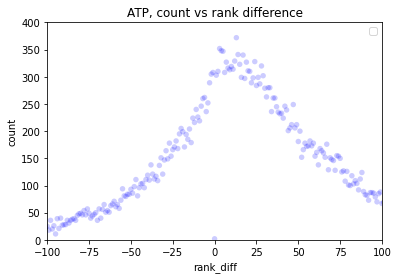

In [15]:
rank_diff_counts_m = df[df.body=='atp'].rank_diff.value_counts()
rank_diff_ys_m = []
rank_diff_xs_m = df[df.body=='atp'].rank_diff.unique()
for x in rank_diff_xs_m:
    rank_diff_ys_m.append(rank_diff_counts_m[x])
thinkplot.Scatter(rank_diff_xs_m, rank_diff_ys_m, alpha=0.2)
thinkplot.Config(xlim=[-100,100],
                 ylim=[0,400],
                 xlabel = 'rank_diff',
                 ylabel = 'count',
                 title = 'ATP, count vs rank difference')

No handles with labels found to put in legend.


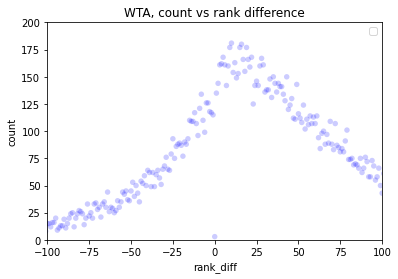

In [16]:
rank_diff_counts_f = df[df.body=='wta'].rank_diff.value_counts()
rank_diff_ys_f = []
rank_diff_xs_f = df[df.body=='wta'].rank_diff.unique()
for x in rank_diff_xs_f:
    rank_diff_ys_f.append(rank_diff_counts_f[x])

thinkplot.Scatter(rank_diff_xs_f, rank_diff_ys_f, alpha=0.2)
thinkplot.Config(xlim=[-100,100],
                 ylim=[0,200],
                 xlabel = 'rank_diff',
                 ylabel = 'count',
                 title = 'WTA, count vs rank difference')

You'll note that there is an outlier datapoint in each of the scatterplots: when rank_diff is 0. This is to be expected. It is not possible in either governing body to have two players of tied ranking, so it never happens that the difference in rankings between a match winner and loser is 0.

Now we'll have a look at the histograms of some of the variables over time. First we will plot the histogram of the dates of tournaments, bucketed into years. This will show us whether the amount of data we have over time is level, or if we should consider eliminating some years for having information gaps for some reason, which would potentially introduce bias due to misrepresentative data from those years. Because the information gathering is separate for the ATP and WTA, I split the data by governing body.

In [17]:
def get_tourney_year(row):
    return math.floor(row.tourney_date/10000)

In [18]:
df['tourney_year'] = df.apply(get_tourney_year, axis = 1)

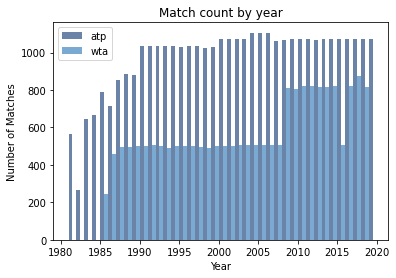

In [19]:
bodies = ['atp','wta']
body_hists = {}
for body in bodies:
    body_hists[body]=thinkstats2.Hist(df[df.body==body].tourney_year,label = body)

    
align={'atp':'left','wta':'right'}
for body in bodies:
    thinkplot.Hist(body_hists[body],align=align[body],width = 0.5)
    thinkplot.Config(xlabel = 'Year',
                     ylabel = 'Number of Matches',
                     title = 'Match count by year')

Along with the men's Masters tournaments switching to best of 3 in 2009, some WTA tournaments were reclassified.

While we're at it, we should check the data by surface, as I intend to use surface as a control later in the analysis to answer the question of whether upset likelihood depends significantly on the court surface.

In [20]:
surfaces = ['Hard','Clay','Grass','Carpet']
surface_hists={}
for surface in surfaces:
    surface_hists[surface]=thinkstats2.Hist(df[df.surface==surface].tourney_year, label = surface)

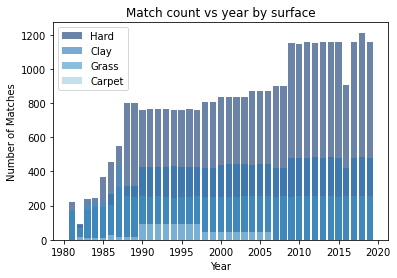

In [21]:
for surface in surfaces:
    thinkplot.Hist(surface_hists[surface], width = 0.8)
    thinkplot.Config(xlabel = 'Year',
                     ylabel = 'Number of Matches',
                     title = 'Match count vs year by surface'.format(surface))

All in all, the data is spotty up until 1990. So I will subset the dataset accordingly to ensure representative data in the analyses to follow. I also note that the carpet surface has disappeared from use. Too bad, as it was a good surface.

Continuing the EDA, we'll have a look at histograms of the rank_diff variable overall, then broken down by gender and surface.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


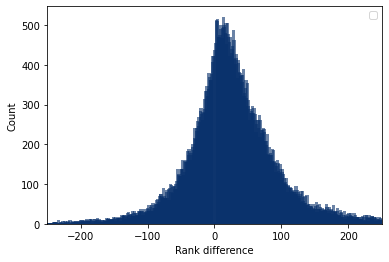

In [22]:
rank_diff_hist = thinkstats2.Hist(df.rank_diff)
thinkplot.Hist(rank_diff_hist, width = 5)
thinkplot.Config(xlim=[-250,250])
thinkplot.Config(xlabel = 'Rank difference',
                 ylabel = 'Count')

It appears that this variable is asymmetrically distributed, with mean and mode a bit above 0, and a heavier tail on the right. This is entirely expected, as we should think that on average the winner will have a better ranking than the loser. Let's check these programmitcally.

In [23]:
print('Rank difference mean: {}.'.format(round(np.mean(df.rank_diff),2)))
print('Rank difference mode: {}.'.format(mode(df.rank_diff)))

Rank difference mean: 31.43.
Rank difference mode: 13.0.


This confirms the conclusions of our visual inspection. The fact that the mean is greater than the mode is consistent with the rightward skew of the data. Another way to verify this would be to calculate the odds that, given an absolute difference in rank between players, the chance that the one with the better ranking wins. We should expect these odds to grow as the absolute difference increases.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


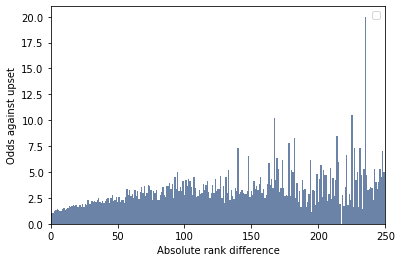

In [24]:
counts = df['rank_diff'].value_counts()
odds = {}
for n in df.rank_diff.unique():
    if n>0 and n<400 and -n in df.rank_diff.unique():
        odds[n]=counts[n]/counts[-n]

odds_hist = thinkstats2.Hist(odds)

thinkplot.Hist(odds_hist, width = 1)
thinkplot.Config(xlim=[0,250])
thinkplot.Config(xlabel = 'Absolute rank difference',
                 ylabel = 'Odds against upset')

Indeed, as expected, with a rank difference closer to magnitude 0, the odds are about even, as we should expect. As the magnitude of rank difference gets large, the odds of the better ranked player winning increases. Note that the graph becomes noisier the farther we go right - this can be attributed to fewer examples of each rank difference. For example, it's not often that two players with a difference of rank of exactly 240 play each other. That tall spike around 240, then, would be due to relatively few examples, with by chance fewer than expected being won by the lower ranked player. These outliers should thus be disregarded.  

To get further insight into the likely effects of gender on upset probability, we can plot the PMFs for the rank_diff variable broken down by gender.

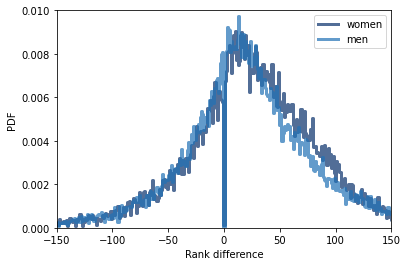

<Figure size 576x432 with 0 Axes>

In [25]:
rank_diff_m_pmf = thinkstats2.Pmf(df[df.body=='atp'].rank_diff, label = 'men')
rank_diff_f_pmf = thinkstats2.Pmf(df[df.body=='wta'].rank_diff, label = 'women')
thinkplot.Pmfs([rank_diff_f_pmf,rank_diff_m_pmf])
thinkplot.Show(xlabel='Rank difference',
               ylabel='PDF',
               axis=[-150, 150,0,.01])

Nothing really stands out here (besides the outlier at 0, previously discussed). Perhaps by zooming in a bit horizontally we can discern more detail.

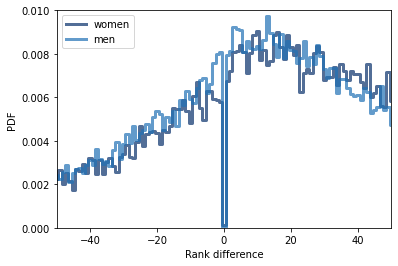

<Figure size 576x432 with 0 Axes>

In [26]:
thinkplot.Pmfs([rank_diff_f_pmf,rank_diff_m_pmf])
thinkplot.Show(xlabel='Rank difference',
               ylabel='PDF',
               axis=[-50, 50,0,.01])

Again, I don't see any significant differences. Fortunately, statistical techniques can reveal information the eye doesn't see, so we will see later that there are indeed statistically significant differences in these two graphs.

It may help us to analyze the above curve to look at the CDFs of the two distributions.

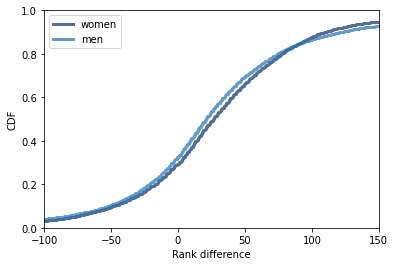

<Figure size 576x432 with 0 Axes>

In [27]:
rank_diff_m_cdf = thinkstats2.Cdf(df[df.body == 'atp'].rank_diff, label = 'men')
rank_diff_f_cdf = thinkstats2.Cdf(df[df.body == 'wta'].rank_diff, label = 'women')
thinkplot.Cdfs([rank_diff_f_cdf,rank_diff_m_cdf])
thinkplot.Show(xlabel='Rank difference',
               ylabel='CDF',
               axis=[-100,150,0,1])

You'll note that the ATP curve is on top of the WTA curve for most of the view window. This indicates that the men's curve has picked up more values earlier, and the women's curve catches up later, indicating a slightly more rightward weight to the values in the women's curve. This would suggest that a greater percentage of WTA than ATP matches are won by a largely better ranked opponent.

## Regression analysis

As there is a clear increasing trend, we might try computing Pearson's correlation coefficient. 

In [28]:
rank_diff_cdf = thinkstats2.Cdf(df.rank_diff)
xs, ps = rank_diff_cdf.Render()
print('Covariance: ',thinkstats2.Cov(xs,ps))
print('Correlation:',thinkstats2.Corr(xs,ps))

Covariance:  165.2656017477062
Correlation: 0.8401377662532928


The positive covariance indicates that the two move together, which we can tell from the CDF. The correlation of 0.82 says that the association is rather strong. However, widening the view window shows that the data is significantly nonlinear. 

No handles with labels found to put in legend.


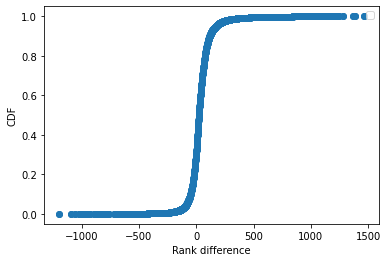

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(xs, ps, 'o')
thinkplot.Config(xlabel = 'Rank difference',
                 ylabel = 'CDF')

The CDF looks like a good candidate for modeling by a logistic curve. So I'll use scipy to fit one. I will use regression analysis to fit a logistic curve of the form $f(x)=a+\frac{b}{1+e^{c(x+d)}}$ to the data.

In [30]:
def f(x, a, b, c, d):
    return a+b/(1+np.exp(c*(x+d)))
(a,b,c,d), _ = opt.curve_fit(f, xs, ps)
print(a,b,c,d)

0.9878886698736408 -0.9838515276719958 0.028186349269140844 -24.845214323143676


<ipython-input-30-816ca1237d74>:2: RuntimeWarning: overflow encountered in exp
  return a+b/(1+np.exp(c*(x+d)))


The logistic curve of best fit is $f(x)=0.988-\frac{0.984}{1+e^{0.0282(x-24.8)}}$.

No handles with labels found to put in legend.


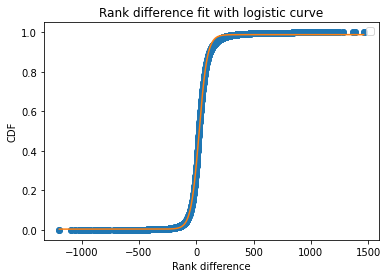

In [31]:
y_fit = f(xs, a, b, c, d)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(xs, ps, 'o')
ax.plot(xs, y_fit, '-')
thinkplot.Config(xlabel = 'Rank difference',
                 ylabel = 'CDF',
                 title = 'Rank difference fit with logistic curve')

We can differentiate this CDF to get an analytic approximation to the probability distribution. We get $\text{pdf}(x)=-\frac{bc}{\left(1+e^{cx+d}\right)^2}e^{cx+d}.$

In [32]:
def pdf(x):
    return -b*c/(1+np.exp(c*(x+d)))**2*np.exp(c*(x+d))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


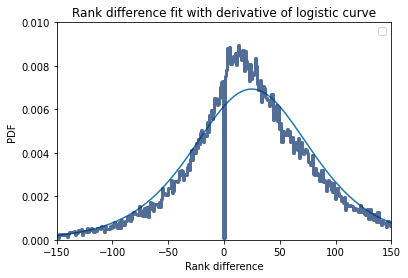

<Figure size 576x432 with 0 Axes>

In [33]:
pdf_fit=pdf(xs)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(xs, pdf_fit, '-')
thinkplot.Config(xlabel = 'Rank difference',
                 ylabel = 'PDF',
                 title = 'Rank difference fit with derivative of logistic curve')
rank_diff_pmf = thinkstats2.Pmf(df.rank_diff)
thinkplot.Pmf(rank_diff_pmf)
thinkplot.Show(xlabel='Rank difference',
               ylabel='PDF',
               axis=[-150, 150,0,.01])

The curve fits the pmf fairly well. It captures the right skew, but it is not sharp enough and there is a noticeable gap around the mode. I am not aware of any elementary probability distributions that would be a better fit. The lognormal distribution is out, because it accepts only a positive domain.

In [34]:
log_RMSE = np.sqrt(np.mean((y_fit-ps)**2))
print('The logistic curve has an RMSE of {}.'.format(round(log_RMSE,4)))

The logistic curve has an RMSE of 0.0103.


We can compare the goodness of fit here by fitting a linear model and computing the RMSE.

No handles with labels found to put in legend.


The logistic curve has an RMSE of 0.2462.
The line RMSE is 23.8 times greater than that of the logistic curve.


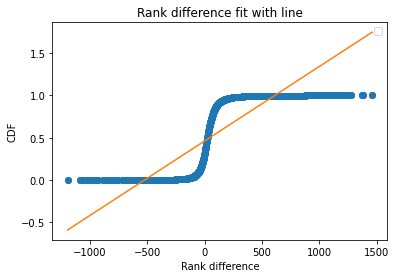

In [35]:
def lm(x, a, b):
    return a*x+b
(e,f),_ = opt.curve_fit(lm, xs, ps)
y_fit_lin = lm(xs, e, f)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(xs, ps, 'o')
ax.plot(xs, y_fit_lin, '-')
thinkplot.Config(xlabel = 'Rank difference',
                 ylabel = 'CDF',
                 title = 'Rank difference fit with line')
lin_RMSE = np.sqrt(np.mean((y_fit_lin-ps)**2))

print('The logistic curve has an RMSE of {}.'.format(round(lin_RMSE,4)))
print('The line RMSE is {} times greater than that of the logistic curve.'.format(round(lin_RMSE/log_RMSE,1)))

## The hypothesis tests

In [36]:
# This class code is sourced from ThinkStats

class DiffMeansPermute(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Now we'll get to the computing. We'll use hypothesis testing in order to determine whether there are statistically significant differences in the rank_diff data when viewed by gender and surface. I'll make a function which will conduct a hypothesis test on differences of means, cutting the data along a user-specified variable and with user-specified values.

In [37]:
def tennis_hyp_test(df, col, val1, val2, title = ''):
    data = df[df[col]==val1].rank_diff, df[df[col]==val2].rank_diff
    ht = DiffMeansPermute(data)
    pvalue = ht.PValue()
    ht.PlotCdf()
    if title == '':
        title = 'Difference of means: {} vs {}'.format(val1,val2)
    thinkplot.Show(xlabel='test statistic',
                   ylabel='CDF',
                   title = title)
    print('pvalue: {}'.format(pvalue))
    if pvalue<0.05:
        res='is'
    else:
        res='is not'
    print('\n{} mean: {} '.format(val1,np.mean(df[df[col]==val1]['rank_diff'])))
    print('\n{} mean: {} '.format(val2,np.mean(df[df[col]==val2]['rank_diff'])))
    print('\nThe difference of means between {} and {} {} statistically significant.'.format(val1, val2, res))

No handles with labels found to put in legend.


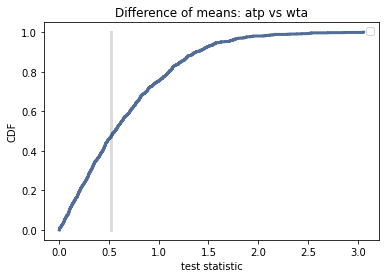

pvalue: 0.528

atp mean: 31.248446227676816 

wta mean: 31.772488098220997 

The difference of means between atp and wta is not statistically significant.


<Figure size 576x432 with 0 Axes>

In [38]:
tennis_hyp_test(df,'body','atp','wta')

So it turns out that the means between the men's and women's rank_diff is not statistically significant. Let's check some mean differences by surface.

No handles with labels found to put in legend.


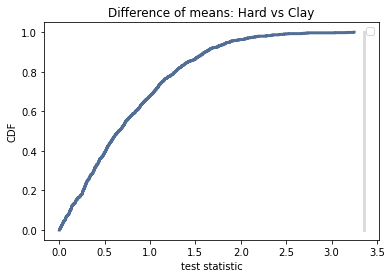

pvalue: 0.0

Hard mean: 32.19164147140338 

Clay mean: 28.837559172556904 

The difference of means between Hard and Clay is statistically significant.


<Figure size 576x432 with 0 Axes>

In [39]:
tennis_hyp_test(df,'surface','Hard','Clay')

No handles with labels found to put in legend.


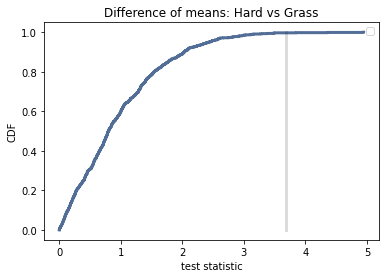

pvalue: 0.003

Hard mean: 32.19164147140338 

Grass mean: 35.87889812889813 

The difference of means between Hard and Grass is statistically significant.


<Figure size 576x432 with 0 Axes>

In [40]:
tennis_hyp_test(df,'surface','Hard','Grass')

It appears that upsets are more likely on clay than on hard court, and in turn are more likely on hard court than on grass. This is unsurprising to me for the following reason. Clay courts are slowest, grass courts are fastest, with hard courts falling somewhere in the middle. This means that clay matches give players more opportunity to "fight" for points, with the result that a player's natural daily fluctuations in stamina and will can have a greater impact on clay matches than grass. That is, a lower ranked player has a better chance of pulling off an upset by showing a lot of "heart" on clay than grass.

You'll recall the carpet data was sparse, but just out of curiosity, we can check carpet as well. Carpet is acknowledged as falling between hard and grass in speed. Based on the above explanation, we expect clay < hard < carpet < grass.

No handles with labels found to put in legend.


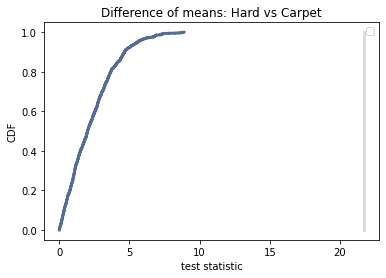

pvalue: 0.0

Hard mean: 32.19164147140338 

Carpet mean: 10.50888030888031 

The difference of means between Hard and Carpet is statistically significant.


<Figure size 576x432 with 0 Axes>

In [41]:
tennis_hyp_test(df,'surface','Hard','Carpet')

And this is not at all what we observe. The surprising result can perhaps be chalked up to the signficant lack of data on carpet, as well as the fact that no grand slam tournaments have been played on carpet.

Since we earlier separated the ATP matches into best of 3 and best of 5, we will now use this data to check whether it has an impact on rank_diff by surface.

No handles with labels found to put in legend.


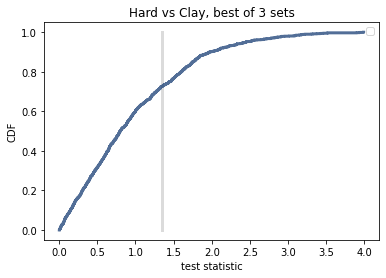

pvalue: 0.275

Hard mean: 28.43316022311983 

Clay mean: 27.088230983438372 

The difference of means between Hard and Clay is not statistically significant.


<Figure size 576x432 with 0 Axes>

In [42]:
tennis_hyp_test(df[df.best_of == 3],'surface','Hard','Clay', title = 'Hard vs Clay, best of 3 sets')

No handles with labels found to put in legend.


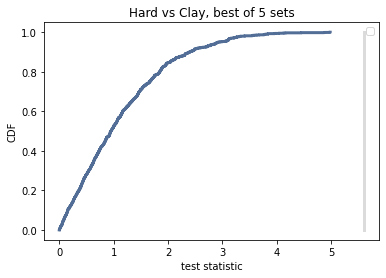

pvalue: 0.0

Hard mean: 35.82030331166821 

Clay mean: 30.225750174459176 

The difference of means between Hard and Clay is statistically significant.


<Figure size 576x432 with 0 Axes>

In [43]:
tennis_hyp_test(df[df.best_of == 5],'surface','Hard','Clay', title = 'Hard vs Clay, best of 5 sets')

The difference in means between the clay and hard surfaces is not significant in best-of-3-set tournaments, but it is significant in the best-of-5-set tournaments. If I can provide a post-hoc explanation for this one, it would be that the gruelling effects of the clay match style accumulate nonlinearly over longer time periods, causing the effect to be exaggerated in the best-of-5-set matches.

No handles with labels found to put in legend.


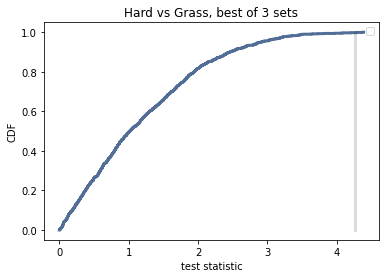

pvalue: 0.002

Hard mean: 28.43316022311983 

Grass mean: 32.70194534506716 

The difference of means between Hard and Grass is statistically significant.


<Figure size 576x432 with 0 Axes>

In [44]:
tennis_hyp_test(df[df.best_of == 3],'surface','Hard','Grass', title = 'Hard vs Grass, best of 3 sets')

No handles with labels found to put in legend.


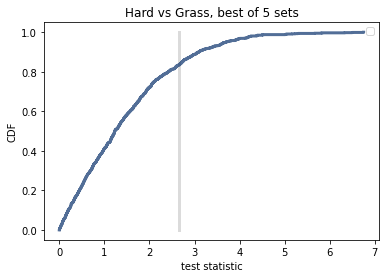

pvalue: 0.166

Hard mean: 35.82030331166821 

Grass mean: 38.46623915503584 

The difference of means between Hard and Grass is not statistically significant.


<Figure size 576x432 with 0 Axes>

In [45]:
tennis_hyp_test(df[df.best_of == 5],'surface','Hard','Grass', title = 'Hard vs Grass, best of 5 sets')

Interestingly, the result is reversed for hard and grass surfaces, in that the result is no longer significant for best-of-5 tournaments. You'll also note, however, that the mean for the best-of-5 on hard courts is up around where the mean for the grass court overall was. This suggests that the higher ranked players have a significant comparative advantage in best-of-5 versus best-of-3 on hard courts, which is not inconsistent with any of the above conclusions. 